Dispositivo: cuda
Clase 0: 1500 imágenes
Clase 1: 1500 imágenes
Clase 2: 1500 imágenes
Clase 3: 1500 imágenes
Clase 4: 1500 imágenes
Clase 5: 1500 imágenes
Clase 6: 1500 imágenes
Clase 7: 1500 imágenes
Clase 8: 1500 imágenes
Clase 9: 1500 imágenes
Dataset final: (15000, 1, 50, 50)

INICIANDO ENTRENAMIENTO
Época 001 | Train Loss: 1.2086 | Acc Loss: 0.5897Val Loss: 0.2226 | Acc: 0.9343
   Mejor modelo guardado!
Época 002 | Train Loss: 0.5861 | Acc Loss: 0.8069Val Loss: 0.1963 | Acc: 0.9350
   Mejor modelo guardado!
Época 003 | Train Loss: 0.4594 | Acc Loss: 0.8585Val Loss: 0.1391 | Acc: 0.9563
   Mejor modelo guardado!
Época 004 | Train Loss: 0.3870 | Acc Loss: 0.8788Val Loss: 0.1725 | Acc: 0.9467
Época 005 | Train Loss: 0.3534 | Acc Loss: 0.8894Val Loss: 0.1195 | Acc: 0.9590
   Mejor modelo guardado!
Época 006 | Train Loss: 0.3342 | Acc Loss: 0.8956Val Loss: 0.0916 | Acc: 0.9683
   Mejor modelo guardado!
Época 007 | Train Loss: 0.3257 | Acc Loss: 0.9021Val Loss: 0.0950 | Acc: 0.9690
   

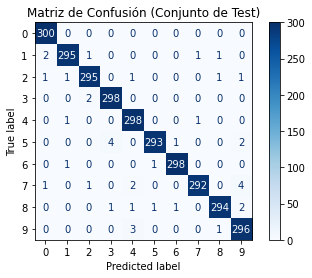

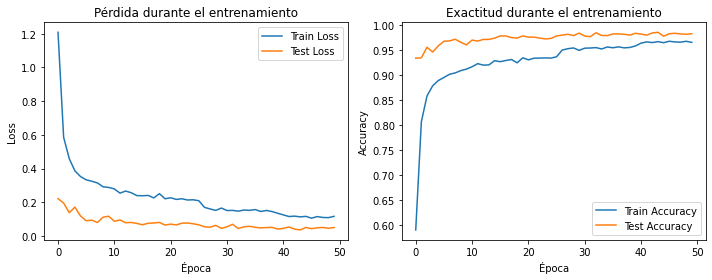

In [3]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as v2
from torchvision import transforms

# CONFIGURACION INICIAL

IMG_SIZE = 50
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 10
LEARNING_RATE = 0.001
MAX_IMGS_PER_CLASS = 1500
DATA_DIR = r"C:\Users\ehevi\Desktop\PyTorch\test_synthetic" # DIRECTORIO DE UBICACION DEL SET DE IMAGENES
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
print(f"Dispositivo: {DEVICE}")

# PARA ESTE PROYECTO SE UTILIZARON 1000 IMAGENES POR CLASES

def cargar_dataset_limitado(ruta_base, max_imgs=1500):
    
    """
    Carga un dataset limitado de imágenes clasificadas por dígitos (0-9).
    
    Carga imágenes desde carpetas etiquetadas por dígito, limitando la cantidad
    máxima por clase, redimensionándolas y normalizándolas para procesamiento.
    
    Parameters:
    -----------
    ruta_base : str
        Ruta base donde se encuentran las carpetas 0-9 con imágenes
    max_imgs : int, default=1000
        Número máximo de imágenes a cargar por clase/dígito
    
    Returns:
    --------
    X : ndarray, shape (N, 1, IMG_SIZE, IMG_SIZE)
        Array de imágenes en escala de grises normalizadas
    y : ndarray, shape (N,)
        Array de etiquetas correspondientes a los dígitos (0-9)
    
    Notes:
    ------
    - Las imágenes se redimensionan a IMG_SIZE x IMG_SIZE
    - Se cargan solo archivos .png, .jpg, .jpeg
    - Si hay más imágenes que max_imgs por clase, se muestrean aleatoriamente
    - Las imágenes se convierten a float32 y se añade dimensión de canal
    """
    
    X, y = [], []
    for digito in range(10):
        carpeta = os.path.join(ruta_base, str(digito))
        archivos = [f for f in os.listdir(carpeta) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(archivos) > max_imgs:
            archivos = random.sample(archivos, max_imgs)
        
        print(f"Clase {digito}: {len(archivos)} imágenes")
        
        for f in archivos:
            img = cv2.imread(os.path.join(carpeta, f), cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(digito)
    
    X = np.array(X, dtype=np.float32)
    X = np.expand_dims(X, axis=1)          # (N, 1, 50, 50)
    y = np.array(y, dtype=np.int64)
    print(f"Dataset final: {X.shape}")
    return X, y

X, y = cargar_dataset_limitado(DATA_DIR, MAX_IMGS_PER_CLASS)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# CLASE PARA AÑADIR RUIDO GAUSSIANO A LAS IMAGENES

class AddGaussianNoise(object):
    
    """
    Transformador que añade ruido gaussiano a tensores.
    
    Aplica ruido gaussiano con media y desviación estándar especificadas
    a tensores de entrada durante el aumento de datos.
    
    Parameters:
    -----------
    mean : float, default=0.0
        Media de la distribución gaussiana
    std : float, default=0.05
        Desviación estándar de la distribución gaussiana
    """
    
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Transformaciones para data augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.15,0.15), scale=(0.85,1.15), shear=15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    AddGaussianNoise(std=0.05),   # RUIDO GAUSSIANO
])

# Dataset simple y rápido
class DigitDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = torch.from_numpy(imgs).float() / 255.0   # normaliza y convierte a tensor
        self.labels = torch.from_numpy(labels).long()
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = self.imgs[i]  # [1,50,50]
        if self.transform:
            img = self.transform(img)
        return img, self.labels[i]

# Creamos los datasets
train_ds = DigitDataset(X_train, y_train, transform=train_transform)
test_ds  = DigitDataset(X_test, y_test)  # sin augmentations

# Creamos los dataloaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# RED NEURONAL
class EnhancedDigitCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),   nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),  nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, 3, padding=1),  nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256), nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = EnhancedDigitCNN().to(DEVICE)
#print(model) muestra los detalles de la red neuronal convolucional


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, min_lr=1e-7, verbose=True)

best_val_acc = 0.0
patience_es = 12
counter = 0

# LOOP DE ENTRENAMIENTO

print("\n" + "="*60)
print("INICIANDO ENTRENAMIENTO")
print("="*60)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * x.size(0)
        _, pred = out.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()
    
    epoch_train_loss = train_loss / total
    epoch_train_acc = correct / total
    
    # Validación
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            val_total += y.size(0)
            val_correct += pred.eq(y).sum().item()
    
    epoch_test_loss = val_loss / val_total
    epoch_test_acc = val_correct / val_total
    
    # GUARDANDO DATOS DE LAS METRICA
    train_loss_list.append(epoch_train_loss)
    train_acc_list.append(epoch_train_acc)
    test_loss_list.append(epoch_test_loss)
    test_acc_list.append(epoch_test_acc)
    
    print(f"Época {epoch:03d} | Train Loss: {epoch_train_loss:.4f} | Acc Loss: {epoch_train_acc:.4f}"
          f"Val Loss: {epoch_test_loss:.4f} | Acc: {epoch_test_acc:.4f}")
    
    scheduler.step(epoch_test_loss)
    
    if epoch_test_acc > best_val_acc:
        best_val_acc = epoch_test_acc
        counter = 0
        torch.save(model.state_dict(), "modelo_digitos_50x50.pth")
        print("   Mejor modelo guardado!")
    else:
        counter += 1
        if counter >= patience_es:
            print("   Early stopping activado")
            break

print(f"\nEntrenamiento terminado. Mejor precisión en validación: {best_val_acc:.4f}")

# Evaluación final
model.load_state_dict(torch.load("modelo_digitos_50x50.pth"))
model.eval()
preds, trues = [], []
with torch.no_grad():
    for x, y in test_dl:
        preds.extend(model(x.to(DEVICE)).argmax(1).cpu().numpy())
        trues.extend(y.numpy())

print(f"Precisión final en test: {np.mean(np.array(preds) == np.array(trues)):.4f}")
print(classification_report(trues, preds, digits=4))

cm = confusion_matrix(trues, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión (Conjunto de Test)")
plt.show()

# GRAFICO DE DESEMPEÑO DEL MODELO

plt.figure(figsize=(10,4))

# GRAFICO DE PERDIDA-
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()

# GRAFICO DE ACCURACY
plt.subplot(1,2,2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Exactitud durante el entrenamiento')
plt.legend()

plt.tight_layout()
plt.show()